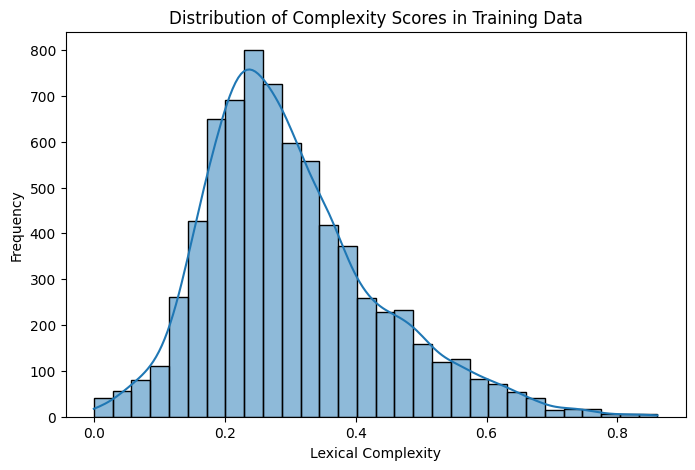


Model Performance Comparison:
                        MAE
Linear Regression  0.104156
Random Forest      0.104774
XGBoost            0.102099


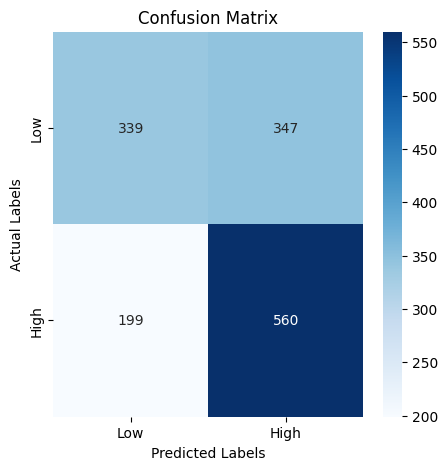

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Predictions saved to lcp_test_predictions.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, confusion_matrix

# GitHub Dataset Links
train_url = "https://raw.githubusercontent.com/UdayPrasadB/NLP_Assignment/main/lcp_single_train.tsv"
test_url = "https://raw.githubusercontent.com/UdayPrasadB/NLP_Assignment/main/lcp_single_test.tsv"

# Load datasets
train_df = pd.read_csv(train_url, sep='\t')
test_df = pd.read_csv(test_url, sep='\t')

# Drop missing values in the token column
train_df.dropna(subset=['token'], inplace=True)

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(8, 5))
sns.histplot(train_df['complexity'], bins=30, kde=True)
plt.xlabel("Lexical Complexity")
plt.ylabel("Frequency")
plt.title("Distribution of Complexity Scores in Training Data")
plt.show()

# Feature Engineering
train_df['token_length'] = train_df['token'].apply(len)
train_df['sentence_length'] = train_df['sentence'].apply(lambda x: len(x.split()))

def get_token_position(row):
    words = row['sentence'].split()
    return words.index(row['token']) / len(words) if row['token'] in words else -1

train_df['token_position'] = train_df.apply(get_token_position, axis=1)
word_freq = train_df['token'].str.lower().value_counts().to_dict()
train_df['token_frequency'] = train_df['token'].str.lower().apply(lambda x: word_freq.get(x, 0))

# Define features and target variable
features = ['token_length', 'sentence_length', 'token_position', 'token_frequency']
X = train_df[features]
y = train_df['complexity']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define regression models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    results[name] = {
        "MAE": mean_absolute_error(y_val, y_pred)
    }

# Display model performance
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)

# Generate Confusion Matrix
threshold = y.median()
y_val_categorical = (y_val >= threshold).astype(int)
y_pred_categorical = (model.predict(X_val_scaled) >= threshold).astype(int)
conf_matrix = confusion_matrix(y_val_categorical, y_pred_categorical)

# Plot Confusion Matrix
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

# Hyperparameter tuning for best model
best_model_name = min(results, key=lambda x: results[x]["MAE"])
best_model = models[best_model_name]

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(XGBRegressor(objective="reg:squarederror"), param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_model = XGBRegressor(**grid_search.best_params_, random_state=42)
best_model.fit(X_train_scaled, y_train)

test_df['token_length'] = test_df['token'].apply(len)
test_df['sentence_length'] = test_df['sentence'].apply(lambda x: len(x.split()))
test_df['token_position'] = test_df.apply(get_token_position, axis=1)
test_df['token_frequency'] = test_df['token'].str.lower().apply(lambda x: word_freq.get(x, 0))

X_test = scaler.transform(test_df[features])
test_predictions = best_model.predict(X_test)

test_df['predicted_complexity'] = test_predictions
test_df[['id', 'token', 'predicted_complexity']].to_csv("lcp_test_predictions.csv", index=False)

print("Predictions saved to lcp_test_predictions.csv")